In [1]:
import glob

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
from pathlib import Path
import re
import glob 
from tqdm import tqdm
import gzip
import random
import numpy as np
from collections import defaultdict
from scipy.sparse import csr_matrix
from datetime import datetime


In [17]:
# Ugly duplication of code
def load_data(filepath, headers=None, sep="\t", bad_lines="warn"):
    """
    Loads clickstream data and performs basic cleaning (lowercasing and dropping NaNs).
    :param bad_lines: Defines what to do when encountering a line with too many fields
    :type bad_lines: str (default: "warn")
    :param sep: Delimiter in file.
    :type sep: str
    :param headers: Column headers for file.
    :type headers: list (default: clickstream headers)
    :param filepath: Path to file.
    :type filepath: str
    :return: Cleaned data loaded from given file.
    :rtype: pandas dataframe
    """
    if headers is None:
        headers = ["prev", "curr", "type", "n"]
    filepath = str(filepath)
    if filepath.endswith(".gz"):
        with gzip.open(filepath, "rt", encoding="utf-8") as file_obj:
            clickstream = pd.read_csv(
                file_obj, sep=sep, names=headers, on_bad_lines=bad_lines
            )
    else:
        clickstream = pd.read_csv(
            filepath, sep=sep, names=headers, on_bad_lines=bad_lines
        )
    cols = clickstream.columns
    for col in tqdm(cols, desc="Processing text"):
        try:
            if clickstream[col].dtype == "O":
                clickstream.loc[:, col] = clickstream[col].str.lower()
        except AttributeError as e:
            print(f"Check for non-string datatypes: {e}")
    clickstream.dropna(inplace=True)
    return clickstream

def get_paths(directory, pattern):
    """
    Creates list of filepaths matching the given pattern in the given directory.
    :param directory: Directory containing files of interest.
    :type directory: str
    :param pattern: Pattern of filenames of interest.
    :type pattern: str
    :return: All filenames matching the given pattern in the given directory.
    :rtype: list of strings
    """
    directory_path = Path(directory)
    return directory_path.glob(pattern)

def build_graph(df, from_node="prev", to_node="curr", weight="n"):
    """
    Creates directed graph from given dataframe, with edge weights equal to clicks.
    :param df: Pages with clickstream data.
    :type df: Dataframe
    :param from_node: Name of column containing click origin pages
    :type from_node: str
    :param to_node: Name of column where containing click destination pages
    :type to_node: str
    :param weight: Number of clicks
    :type weight: int
    :return: Clickstream graph
    :rtype: NetworkX object
    """
    g = nx.DiGraph()
    from_nodes = list(df[from_node])
    to_nodes = list(df[to_node])
    weights = list(df[weight])

    for fnode, tnode, wt in zip(from_nodes, to_nodes, weights):
        if fnode == tnode:
            print(f" WARN: self-edge {fnode, tnode}")
        g.add_edge(fnode, tnode, weight=wt)
    return g


def get_transition_matrix(g):
    num_nodes = g.number_of_nodes()
    node_mapping = {node: i for i, node in enumerate(g.nodes)}
    row_idx = []
    col_idx = []
    data = []
    
    for node in g.nodes:
        out_edges = list(g.out_edges(node))
        out_weights = [g.edges[edge]["weight"] for edge in out_edges]
        total_weights = sum(out_weights)
        if total_weights > 0:
            normalized_weights = [w / total_weights for w in out_weights]
            row_idx.extend([node_mapping[node]] * len(out_edges))
            col_idx.extend([node_mapping[j] for i, j in out_edges])
            data.extend(normalized_weights)
    trans_matrix = csr_matrix((data, (row_idx, col_idx)), shape=(num_nodes, num_nodes), dtype=np.float64)
    
    # Make column stochastic
    col_stoch_trans_matrix = trans_matrix.transpose()
    return col_stoch_trans_matrix

def random_walk(g, trans_matrix, start, length=3):
    # Initialize dict of visited pages
    visited = defaultdict(int)
    
    # Set starting node
    node_list = list(g.nodes())
    print(node_list[:5])
    start_page = node_list.index(start)
    print(start_page)
    page = np.zeros(len(node_list))
    page[start_page] = 1
    print(page)    
    
    # Run random walk
    for _ in tqdm(range(length), desc="Random Walk Progress"):
        print("enter walk")
        transition_probs = trans_matrix.dot(page)
        visit = np.random.choice(len(page), p=transition_probs)
        visited[visit] += 1
        page = np.zeros_like(page)
        page[visit] = 1
    return visited

In [19]:
headers = ["prev", "curr", "type", "n"]
clicks202303 = pd.read_csv("../data/clickstream-enwiki-2023-03.tsv", sep="\t", names=headers)

In [20]:
clicks202303.head(5)

,prev,curr,type,n
0,2023_Baltimore_Ravens_season,Shemar_Bridges,link,66.0
1,Indiana_Jones_and_the_Dial_of_Destiny,Avatar:_The_Way_of_Water,other,39.0
2,other-search,Shemar_Bridges,external,80.0
3,List_of_West_Bromwich_Albion_F.C._managers,Brian_Talbot,link,28.0
4,List_of_current_AFC_team_rosters,Shemar_Bridges,link,20.0


In [21]:
print(f"Length: {len(clicks202303)}")
print(f"Nulls: {clicks202303.isna().sum().sum()}")
clicks202303.info()

Length: 33391772
Nulls: 88
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33391772 entries, 0 to 33391771
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   prev    object 
 1   curr    object 
 2   type    object 
 3   n       float64
dtypes: float64(1), object(3)
memory usage: 1019.0+ MB


In [22]:
clicks202303.dropna(inplace=True)
ua_prev = clicks202303[clicks202303['curr'] == 'Russian_invasion_of_Ukraine']
ua_curr = clicks202303[clicks202303['prev'] == 'Russian_invasion_of_Ukraine']

In [23]:
print(f"ua_prev length: {len(ua_prev)}")
print(f"ua_curr length: {len(ua_curr)}")

ua_prev length: 2657
ua_curr length: 572


In [24]:
ua_curr.sort_values(by="n", axis=0, ascending=False)[:50]

,prev,curr,type,n
24427619,Russian_invasion_of_Ukraine,Timeline_of_the_Russian_invasion_of_Ukraine,link,26303.0
18702221,Russian_invasion_of_Ukraine,List_of_military_engagements_during_the_Russia...,link,13179.0
16788488,Russian_invasion_of_Ukraine,Russo-Ukrainian_War,link,8353.0
23113637,Russian_invasion_of_Ukraine,Order_of_battle_for_the_Russian_invasion_of_Uk...,link,7460.0
9481243,Russian_invasion_of_Ukraine,Casualties_of_the_Russo-Ukrainian_War,link,7336.0
31252763,Russian_invasion_of_Ukraine,Wagner_Group,link,5141.0
8086764,Russian_invasion_of_Ukraine,ICC_arrest_warrants_for_Vladimir_Putin_and_Mar...,link,4623.0
31978292,Russian_invasion_of_Ukraine,Battle_of_Bakhmut,link,4519.0
29467903,Russian_invasion_of_Ukraine,Main_Page,other,4132.0
10569448,Russian_invasion_of_Ukraine,Volodymyr_Zelenskyy,link,3974.0


In [25]:
ua_prev.describe()

,n
count,2657.000000
mean,472.970267
std,9173.930777
min,10.000000
25%,15.000000
50%,25.000000
75%,65.000000
max,328720.000000


In [26]:
# Gaza–Israel conflict
# Russian invasion of Ukraine
# 2017 - 2023: clickstream prev and curr

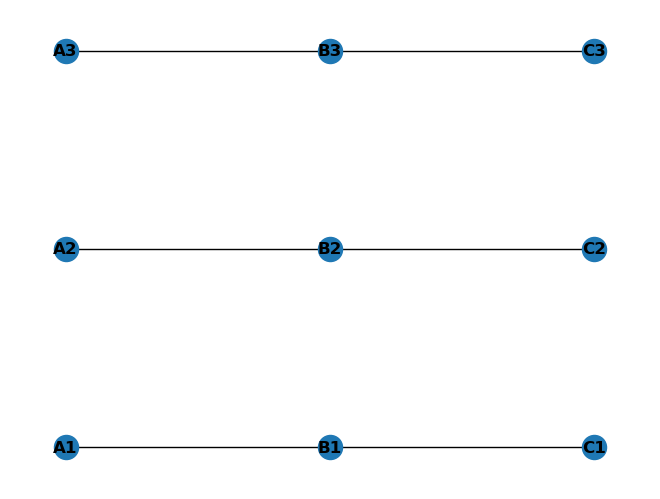

In [27]:

# Create a tripartite graph
G = nx.Graph()
G.add_nodes_from(['A1', 'A2', 'A3'], bipartite=0)  # First partition
G.add_nodes_from(['B1', 'B2', 'B3'], bipartite=1)  # Second partition
G.add_nodes_from(['C1', 'C2', 'C3'], bipartite=2)  # Third partition
G.add_edges_from([('A1', 'B1'), ('A2', 'B2'), ('A3', 'B3')])
G.add_edges_from([('B1', 'C1'), ('B2', 'C2'), ('B3', 'C3')])

# Use bipartite layout for the first two partitions
pos = {node: (0, i) for i, node in enumerate(['A1', 'A2', 'A3'])}
pos.update({node: (1, i) for i, node in enumerate(['B1', 'B2', 'B3'])})
pos.update({node: (2, i) for i, node in enumerate(['C1', 'C2', 'C3'])})

# Draw the tripartite graph
nx.draw(G, pos, with_labels=True, font_weight='bold')
plt.show()

In [98]:
def calc_top_n(directory, page, status="curr"):
    dir_ = Path(directory)
    pattern = dir_ / f"????-??_{page}_clickstream.csv"
    clickstream_files = glob.glob(str(pattern))
    top_ns = list()
    for file in clickstream_files:
        clicks_data = pd.read_csv(file)
        date_pattern = r"(\d{4}-\d{2})"
        match = re.search(date_pattern, str(file))
        file_date = match.group(1)
        clicks_data["month"] = file_date
        top_n = clicks_data.sort_values(by="n", axis=0, ascending=False).head(20)
        top_ns.append(set(top_n[status]))
    return set.intersection(*top_ns)
    
    # for i, top_n_df in enumerate(top_ns):
    #     timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    #     filename = f"../output/temp_test/output_{i}_{timestamp}.csv"
    #     top_n_df.to_csv(filename)
        # first = top_ns[0]
        # for top_n_df in top_ns[1:]:
        #     merged_df = pd.merge(first, top_n_df, on=status, how="inner")

In [99]:
top_pages = calc_top_n("../output/", "ua_prev")

result = top_pages[0].copy()
for s in top_pages[1:]:
    result.intersection_update(s)
result

set()

In [100]:
# top

[{'2022_ukrainian_refugee_crisis',
  'battle_of_donbas_(2022)',
  'battle_of_kharkiv_(2022)',
  'casualties_of_the_russo-ukrainian_war',
  'control_of_cities_during_the_russo-ukrainian_war',
  "donetsk_people's_republic",
  'eastern_ukraine_offensive',
  'list_of_foreign_aid_to_ukraine_during_the_russo-ukrainian_war',
  'list_of_military_engagements_during_the_2022_russian_invasion_of_ukraine',
  'list_of_russian_generals_killed_during_the_2022_invasion_of_ukraine',
  "luhansk_people's_republic",
  'main_page',
  'order_of_battle_for_the_2022_russian_invasion_of_ukraine',
  'russo-ukrainian_war',
  'siege_of_mariupol',
  'timeline_of_the_2022_russian_invasion_of_ukraine',
  'ukraine',
  'vladimir_putin',
  'volodymyr_zelenskyy',
  'war_crimes_in_the_2022_russian_invasion_of_ukraine'},
 {'2022_ukrainian_eastern_counteroffensive',
  '2022_ukrainian_southern_counteroffensive',
  'casualties_of_the_russo-ukrainian_war',
  "donetsk_people's_republic",
  'list_of_foreign_aid_to_ukraine_durin

## Test Random Walker

In [3]:
subset = pd.read_pickle("../all_nodes.pkl")

In [4]:
len(subset)

277479

In [5]:
clickstream_files = get_paths("../data/2017-2023", "clickstream-enwiki-*.tsv.gz")
for file in clickstream_files:
    print(file)

../data/2017-2023/clickstream-enwiki-2023-06.tsv.gz
../data/2017-2023/clickstream-enwiki-2019-07.tsv.gz
../data/2017-2023/clickstream-enwiki-2020-01.tsv.gz
../data/2017-2023/clickstream-enwiki-2017-12.tsv.gz
../data/2017-2023/clickstream-enwiki-2021-07.tsv.gz
../data/2017-2023/clickstream-enwiki-2018-01.tsv.gz
../data/2017-2023/clickstream-enwiki-2022-12.tsv.gz
../data/2017-2023/clickstream-enwiki-2018-03.tsv.gz
../data/2017-2023/clickstream-enwiki-2021-09.tsv.gz
../data/2017-2023/clickstream-enwiki-2021-05.tsv.gz
../data/2017-2023/clickstream-enwiki-2018-11.tsv.gz
../data/2017-2023/clickstream-enwiki-2022-02.tsv.gz
../data/2017-2023/clickstream-enwiki-2022-10.tsv.gz
../data/2017-2023/clickstream-enwiki-2023-08.tsv.gz
../data/2017-2023/clickstream-enwiki-2023-04.tsv.gz
../data/2017-2023/clickstream-enwiki-2019-09.tsv.gz
../data/2017-2023/clickstream-enwiki-2020-03.tsv.gz
../data/2017-2023/clickstream-enwiki-2019-05.tsv.gz
../data/2017-2023/clickstream-enwiki-2020-11.tsv.gz
../data/2017

In [6]:
wiki_201901 = load_data("../data/2017-2023/clickstream-enwiki-2019-01.tsv.gz")

Processing text: 100%|██████████| 4/4 [00:09<00:00,  2.30s/it]


In [7]:
wiki_201901.sample(5)

,prev,curr,type,n
28230870,other-external,upper_harz,external,27
3057311,other-internal,tension_(film),external,12
22495355,muncie_central_high_school,ray_mccallum,link,37
3567246,list_of_the_sopranos_episodes,rat_pack_(the_sopranos),link,1148
16494401,other-search,christian_j._lambertsen,external,70


In [8]:
len(wiki_201901)

30986166

In [9]:
filter_201901 = wiki_201901[(wiki_201901["prev"].isin(page.lower() for page in subset)) & (wiki_201901["curr"].isin(page.lower() for page in subset))]

In [10]:
len(filter_201901)

6532477

In [11]:
filter_201901[filter_201901["prev"] == "the_death_and_life_of_great_american_cities"]

,prev,curr,type,n
2106281,the_death_and_life_of_great_american_cities,urban_density,link,12
3735344,the_death_and_life_of_great_american_cities,allen_road,link,38
5061662,the_death_and_life_of_great_american_cities,le_corbusier,link,18
6651902,the_death_and_life_of_great_american_cities,urban_planning,link,24
8623196,the_death_and_life_of_great_american_cities,deductive_reasoning,link,16
9860157,the_death_and_life_of_great_american_cities,garden_city_movement,link,30
14279771,the_death_and_life_of_great_american_cities,urban_renewal,link,47
14479161,the_death_and_life_of_great_american_cities,the_power_broker,link,32
14939701,the_death_and_life_of_great_american_cities,letchworth,link,10
15541054,the_death_and_life_of_great_american_cities,natural_surveillance,link,17


In [12]:
graph_201901 = build_graph(filter_201901)
len(graph_201901)

 WARN: self-edge ('the_oa', 'the_oa')
 WARN: self-edge ('grand_theft_auto', 'grand_theft_auto')
 WARN: self-edge ('canteen', 'canteen')
 WARN: self-edge ('vic', 'vic')
 WARN: self-edge ('fear_of_the_dark', 'fear_of_the_dark')
 WARN: self-edge ('lala', 'lala')
 WARN: self-edge ('bet', 'bet')
 WARN: self-edge ('raptor', 'raptor')
 WARN: self-edge ('ys', 'ys')
 WARN: self-edge ('sugar_baby', 'sugar_baby')
 WARN: self-edge ('awal', 'awal')
 WARN: self-edge ('genx', 'genx')
 WARN: self-edge ('python', 'python')
 WARN: self-edge ('spice', 'spice')
 WARN: self-edge ("death's_head", "death's_head")
 WARN: self-edge ('nxt', 'nxt')
 WARN: self-edge ('total_depravity', 'total_depravity')
 WARN: self-edge ('jamaica_station', 'jamaica_station')
 WARN: self-edge ('bec', 'bec')
 WARN: self-edge ('deadbeef', 'deadbeef')
 WARN: self-edge ('y_combinator', 'y_combinator')
 WARN: self-edge ('tops', 'tops')
 WARN: self-edge ('ariel', 'ariel')
 WARN: self-edge ('clip', 'clip')
 WARN: self-edge ('philadelphi

243640

In [18]:
random.seed(42)
random_start = random.choice(list(graph_201901.nodes()))


In [19]:
trans_matrix = get_transition_matrix(graph_201901)

In [20]:
print(type(trans_matrix))

<class 'scipy.sparse._csc.csc_matrix'>


In [23]:
random_walk(graph_201901, trans_matrix, random_start, length=3)

['epcot', 'illuminations:_reflections_of_earth', 'fantasmic!', 'list_of_super_bowl_halftime_shows', 'fastpass']
167621
[0. 0. 0. ... 0. 0. 0.]


Random Walk Progress: 100%|██████████| 3/3 [00:00<00:00, 95.99it/s]

enter walk
enter walk
enter walk


defaultdict(int, {36665: 2, 19697: 1})